## Generate an emulator for the correlation function of flicker noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

In [2]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
dtime = 2.
ntime = 2860
t_list = np.arange(ntime) * dtime
n_s = 1.
fc = (1/ntime/dtime/n_s)*2*np.pi
logfc = np.log10(fc)


In [3]:
from flicker_model import flicker_cov_vec


ref_logf0 = -4.  # Reference logf0 for the emulator
wnoise_var = 2.5e-6
logfc = logfc
tau_list = t_list

# Generate training data
alpha_list = np.linspace(1.1, 4, 1000)
alpha_test = np.random.uniform(1.1, 4, 500)


from tqdm import tqdm
corr_list = np.array([flicker_cov_vec(tau_list, 10.**ref_logf0, 10.**logfc, alpha, white_n_variance=0.)
                        for alpha in tqdm(alpha_list)])
corr_test = np.array([flicker_cov_vec(tau_list, 10.**ref_logf0, 10.**logfc, alpha, white_n_variance=0.)
                        for alpha in tqdm(alpha_test)])


100%|██████████| 500/500 [01:41<00:00,  4.94it/s]


In [4]:
# Train the emulator
from MomentEmu import PolyEmu
ind=6
flicker_autocorr_emulator = PolyEmu(alpha_list.reshape(-1,1), 
                                    np.log(corr_list[:,:ind]).reshape(-1,ind), 
                                    X_test=alpha_test.reshape(-1,1), 
                                    Y_test=np.log(corr_test[:,:ind]).reshape(-1,ind),
                                    RMSE_upper=1e-1,
                                    RMSE_lower=1e-4, 
                                    fRMSE_tol=1e-1,
                                    forward=True, 
                                    backward=False, 
                                    max_degree_forward=20, 
                                    return_max_frac_err=True)

flicker_lag_emulator = PolyEmu(alpha_list.reshape(-1,1), 
                               corr_list[:,ind:], 
                                X_test=alpha_test.reshape(-1,1), 
                                Y_test=corr_test[:,ind:],
                                RMSE_upper=1e-1,
                                RMSE_lower=1e-7, 
                                fRMSE_tol=1e-1,
                                forward=True, 
                                backward=False, 
                                max_degree_forward=20, 
                                return_max_frac_err=True)


Generating forward emulator...
Forward emulator generated with degree 13, RMSE_val of 7.491879319929653e-05.
Performing dimension reduction...
Dimension reduced  from 14 modes to 14 modes.
After the dimension reduction, the RMSE: 7.491879319929653e-05, AIC: -9471.10578837588, BIC: -18901.50300284601
Forward emulator maximum fractional error: 0.0004075977590841191. (If the true value is close to 0, this value could be extremely large. This is fine.)
Generating forward emulator...
Candidate models within 10.0% of min RMSE : [12 13 14 15 16 17]
RMSE of candidate models : [3.91000819e-07 3.86210540e-07 3.83984147e-07 3.81915114e-07
 3.79679433e-07 3.77371253e-07]
Selected best model index based on BIC : 17
Forward emulator generated with degree 20, RMSE_val of 3.773712530277161e-07.
Performing dimension reduction...
Dimension reduced  from 21 modes to 21 modes.
After the dimension reduction, the RMSE: 3.773712530277161e-07, AIC: -14748.036378010858, BIC: -29435.00989516309
Forward emulator

In [5]:
from flicker_model import flicker_cov_vec, FlickerCorrEmulator
import numpy as np
from scipy.linalg import toeplitz
from tqdm import tqdm

# Create the emulator
flicker_emulator = FlickerCorrEmulator(logfc=logfc, tau_list=t_list, wnoise_var=2.5e-6,
                                       alpha_training=alpha_list, corr_training=corr_list, 
                                       alpha_test=alpha_test, corr_test=corr_test)

Training emulator for lag>0 ...
Generating forward emulator...
Candidate models within 10.0% of min RMSE : [12 13 14 15 16 17]
RMSE of candidate models : [3.91114247e-07 3.86169904e-07 3.83920037e-07 3.81848514e-07
 3.79612955e-07 3.77305160e-07]
Selected best model index based on BIC : 17
Forward emulator generated with degree 20, RMSE_val of 3.773051595444235e-07.
Performing dimension reduction...
Dimension reduced  from 21 modes to 21 modes.
After the dimension reduction, the RMSE: 3.773051595444235e-07, AIC: -14748.211535157314, BIC: -29435.360209456
Forward emulator maximum fractional error: 0.08490166609414833. (If the true value is close to 0, this value could be extremely large. This is fine.)
Training emulator for lag=0 ...
Generating forward emulator...
Forward emulator generated with degree 18, RMSE_val of 9.553526415015997e-06.
Performing dimension reduction...
Dimension reduced  from 19 modes to 19 modes.
After the dimension reduction, the RMSE: 9.553526415015997e-06, AIC:

In [6]:
alpha_list2 = np.linspace(1.1, 4, 60)
logf0_list2 = np.linspace(-6.0, -3.0, 60)

params_list = []
log_det_list = []

indices = None

from tqdm import tqdm
for logf0 in tqdm(logf0_list2):
    for alpha in alpha_list2:
        params_list.append(np.array([logf0, alpha]))
        # corr = flicker_cov_vec(self.tau_list, 10.**logf0, 10.**self.logfc, alpha, white_n_variance=self.wnoise_var)
        corr = flicker_emulator(logf0, alpha, indices=indices)
        sign, log_det = np.linalg.slogdet(toeplitz(corr))
        assert sign > 0, "{} Covariance matrix is not positive definite!".format((logf0, alpha))
        log_det_list.append(log_det)
params_list = np.array(params_list)
log_det_list = np.array(log_det_list).reshape(-1, 1)


# Generate a random test set:
alpha_test2 = np.random.uniform(1.1, 4, 30)
logf0_test2 = np.random.uniform(-6.1, -2.9, 30)
X_test2 = np.array(list(zip(logf0_test2, alpha_test2)))
Y_test2 = []

for logf0, alpha in tqdm(X_test2):
    # corr = flicker_cov_vec(self.tau_list, 10.**logf0, 10.**self.logfc, alpha, white_n_variance=self.wnoise_var)
    corr = flicker_emulator(logf0, alpha, indices=indices)
    log_det = np.linalg.slogdet(toeplitz(corr))[1]
    Y_test2.append(log_det)

Y_test2 = np.array(Y_test2).reshape(-1, 1)


100%|██████████| 30/30 [00:01<00:00, 15.22it/s]


In [7]:
from flicker_model import LogDetEmulator

logdet_flicker = LogDetEmulator(params_list=params_list, 
                                log_det_list=log_det_list, 
                                X_test=X_test2, Y_test=Y_test2)
    

Generating forward emulator...
Candidate models within 10.0% of min RMSE : [17]
RMSE of candidate models : [0.00138106]
Selected best model index based on BIC : 17
Forward emulator generated with degree 20, RMSE_val of 0.0013810602316102788.
Performing dimension reduction...
Dimension reduced  from 231 modes to 231 modes.
After the dimension reduction, the RMSE: 0.0013810602316102788, AIC: 66.90577253901813, BIC: -45519.72010757121
Forward emulator maximum fractional error: 0.0004029901104153728. (If the true value is close to 0, this value could be extremely large. This is fine.)


In [8]:
log_det_emu = logdet_flicker.log_det_emulator.forward_emulator(params_list)
# print the largest error
print("Largest fractional error in log_det emulator:", np.max(np.abs(log_det_emu - log_det_list)/np.abs(log_det_list)))

Largest fractional error in log_det emulator: 0.0012115492090202214


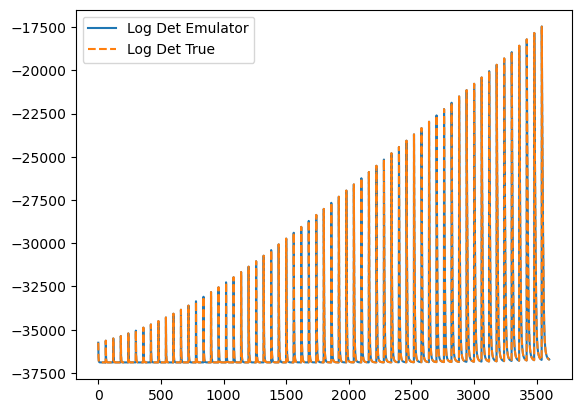

In [9]:
plt.plot(log_det_emu, label='Log Det Emulator')
plt.plot(log_det_list, label='Log Det True', linestyle='--')
plt.legend()
plt.show()

2.571467554294043e-06
2.571469799464331e-06


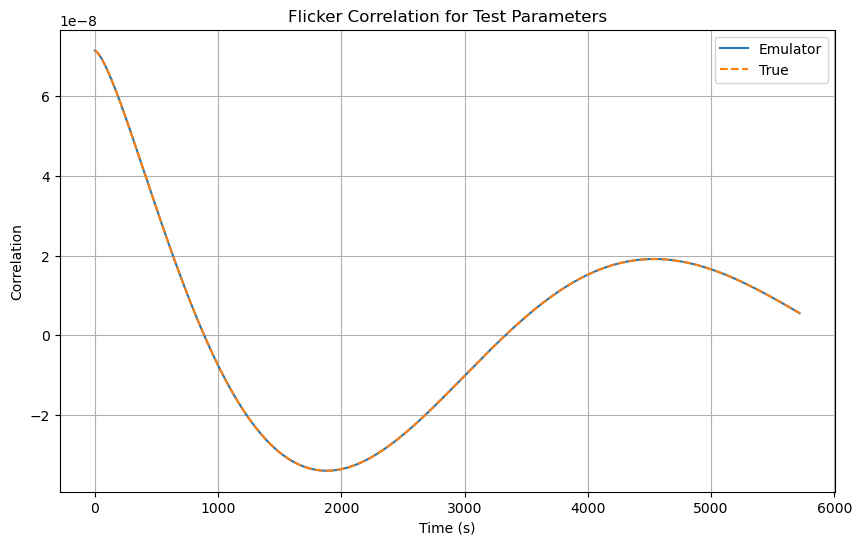

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))


alpha_test_value = 2.5678
logf0_test_value = -4.32  # Example logf0 value, can be adjusted
test_corr = flicker_emulator(logf0=logf0_test_value, alpha=alpha_test_value)
true_corr = flicker_cov_vec(t_list, 10.**logf0_test_value, 10.**logfc, alpha_test_value,  white_n_variance=2.5e-6)
print(test_corr[0])
print(true_corr[0])
plt.plot(t_list[1:], test_corr[1:], label=f'Emulator')
plt.plot(t_list[1:], true_corr[1:], label=f'True', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Correlation')
plt.title('Flicker Correlation for Test Parameters')
plt.legend()
plt.grid()
plt.show()


In [13]:
%timeit test_corr = flicker_emulator(logf0=logf0_test_value, alpha=alpha_test_value)

220 μs ± 2.12 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit true_corr = flicker_cov_vec(t_list, 10.**logf0_test_value, 10.**logfc, alpha_test_value,  white_n_variance=2.5e-6)

179 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# # Save the emulator for later use
import pickle
with open('flicker_corr_emulator.pkl', 'wb') as f:
    pickle.dump(flicker_emulator, f)

with open('flicker_logdet_emulator.pkl', 'wb') as f:
    pickle.dump(logdet_flicker, f)


In [12]:
import pickle
# Load the emulator
with open('../hydra_tod/flicker_corr_emulator.pkl', 'rb') as f:
    flicker_corr_emulator_loaded = pickle.load(f)

with open('../hydra_tod/flicker_logdet_emulator.pkl', 'rb') as f:
    flicker_logdet_emulator_loaded = pickle.load(f)


In [13]:
flicker_corr_emulator_jax = flicker_corr_emulator_loaded.create_jax()

Get the JAX version of the emulators


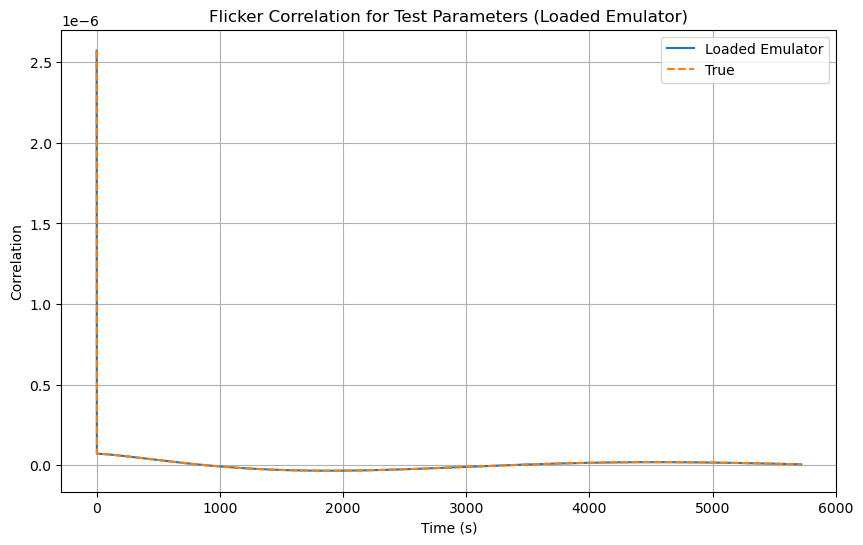

In [22]:
# Test the loaded emulator
test_corr_loaded = flicker_corr_emulator_loaded(logf0=logf0_test_value, alpha=alpha_test_value)
plt.figure(figsize=(10, 6))
plt.plot(t_list, test_corr_loaded, label='Loaded Emulator')
plt.plot(t_list, true_corr, label='True', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Correlation')
plt.title('Flicker Correlation for Test Parameters (Loaded Emulator)')
plt.legend()
plt.grid()
plt.show()  